In [11]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
from friend_groups import *
from modeling import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 36)

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

from itertools import product
from collections import defaultdict

This non-commercial license of GraphLab Create for academic use is assigned to ref302@nyu.edu and will expire on October 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1492213640.log


SETTING UP DATA FOR PREDICTION

In [25]:
mongoClientName = "mongodb://54.70.37.60" # replace XXX with the location of your mongo client
# here I used one of my Amazon EC2 instances and its associated storage as a central location for MongoDB
client = MongoClient(mongoClientName)

In [26]:
allComms = collectAllComms(client)

Checking database 'goodreads_explore_from_book_tnc'
Database has 0 comms (we now have 0 in total)

Checking database 'goodreads_explore_from_book_ender'
Database has 11 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_fault_in_our_stars'
Database has 0 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_hedgehog'
Database has 2 comms (we now have 13 in total)

Checking database 'goodreads_explore_from_book_pride_and_prejudice'
Database has 9 comms (we now have 22 in total)

Checking database 'goodreads_explore_from_book_mice_and_men'
Database has 11 comms (we now have 33 in total)

Checking database 'goodreads_explore_from_book_jest'
Database has 19 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_swiftly'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_floornight'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_fr

In [27]:
dbFull = client['goodreads_full']

ratingsFull = dbFull['ratings']
friendsFull = dbFull['friends']
booksFull = dbFull['books']

#updateCommsOfRaters2(booksFull, allComms)
#updateCommsOfRaters(ratingsFull, booksFull, allComms)
booksToRaterComms = getCommsOfRaters(ratingsFull, allComms)

In [189]:
glRatings = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 7, 25, False)
outlierDict, glRatingsNoOutliers = removeGlOutliers(glRatings)

In [473]:
glRatings = glRatingsNoOutliers

In [191]:
trainSplitRmses = []
trainSplitRmsesFake = []

In [474]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID",
                                                    max_num_users=None,
                                                    item_test_proportion=0.1)
'''

glRatingsTrain, glRatingsTest = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20,\
                                                     True, datetime.strptime('Apr 17, 2013', grDateFormat))

glRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]
glRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]
'''

"\n\nglRatingsTrain, glRatingsTest = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20,                                                     True, datetime.strptime('Apr 17, 2013', grDateFormat))\n\nglRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]\nglRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]\n"

In [25]:
# EDA comparing movielens to GR
# loading data

header = ['user_id', 'item_id', 'rating', 'timestamp']
df_ml = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df_ml = df_ml.rename(columns={'user_id':'userID','item_id':'bookID'})

df_gr = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 7, 25, False).to_dataframe()

In [26]:
# EDA comparing movielens to GR

df_ml_users = df_ml.groupby(['userID'])['rating'].count()
print 'movielens: ratings per user stats\n'
print df_ml_users.describe()

print '\n\ngoodreads: ratings per user stats\n'
df_gr_users = df_gr.groupby(['userID'])['rating'].count()
print df_gr_users.describe()

df_ml_items = df_ml.groupby(['bookID'])['rating'].count()
print '\n\nmovielens: ratings per item stats\n'
print df_ml_items.describe()

print '\n\ngoodreads: ratings per item stats\n'
df_gr_items = df_gr.groupby(['bookID'])['rating'].count()
print df_gr_items.describe()

movielens: ratings per user stats

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64


goodreads: ratings per user stats

count    1154.000000
mean       81.599653
std        59.714390
min        19.000000
25%        39.000000
50%        64.000000
75%       104.000000
max       445.000000
Name: rating, dtype: float64


movielens: ratings per item stats

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64


goodreads: ratings per item stats

count    1826.000000
mean       51.569551
std        67.673647
min         7.000000
25%        11.000000
50%        29.000000
75%        63.750000
max       662.000000
Name: rating, dtype: float64


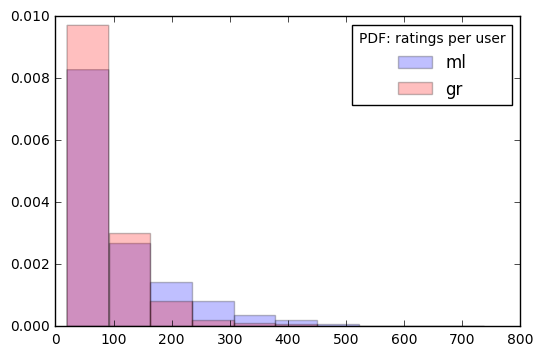

In [11]:
histStuff= plt.hist(df_ml_users,alpha=0.25,normed=True,label='ml');
plt.hist(df_gr_users,alpha=0.25,bins=histStuff[1],normed=True,color='r',label='gr');
plt.legend(title='PDF: ratings per user');

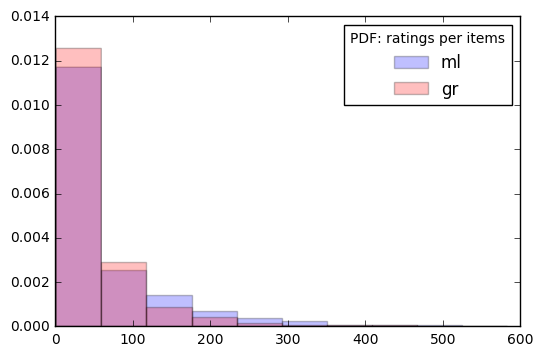

In [12]:
histStuff= plt.hist(df_ml_items,alpha=0.25,normed=True,label='ml');
plt.hist(df_gr_items,alpha=0.25,bins=histStuff[1],normed=True,color='r',label='gr');
plt.legend(title='PDF: ratings per items');

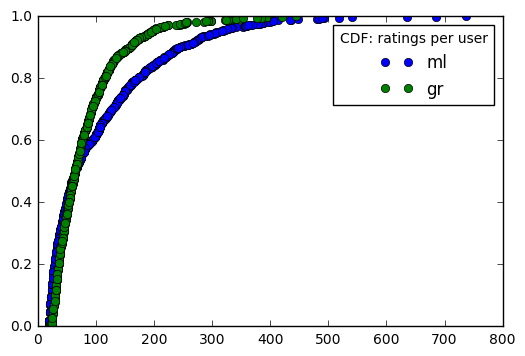

In [13]:
plt.plot(df_ml_users,df_ml_users.rank()/len(df_ml_users.rank()),'o',label='ml');
plt.plot(df_gr_users,df_gr_users.rank()/len(df_gr_users.rank()),'o',label='gr');
plt.legend(title='CDF: ratings per user');

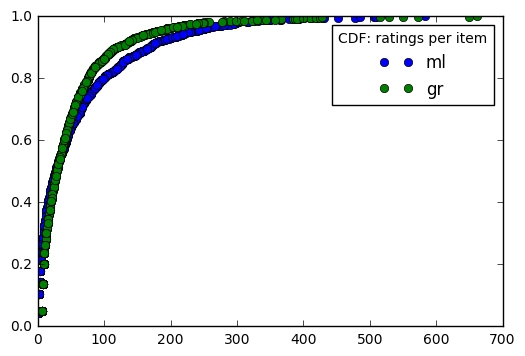

In [14]:
plt.plot(df_ml_items,df_ml_items.rank()/len(df_ml_items.rank()),'o',label='ml');
plt.plot(df_gr_items,df_gr_items.rank()/len(df_gr_items.rank()),'o',label='gr');
plt.legend(title='CDF: ratings per item');

In [99]:
# testing on movielens

header = ['user_id', 'item_id', 'rating', 'timestamp']
df_ml = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df_ml = df_ml.rename(columns={'user_id':'userID','item_id':'bookID'})

glRatings = gl.SFrame(df_ml)

glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID",
                                                    max_num_users=None,
                                                    item_test_proportion=0.1)
                                                    

In [11]:
# removing intercept and user/book means

intercept = glRatingsTrain['rating'].mean()

glRatingsTrain['rating'] = glRatingsTrain['rating'] - intercept

userMeans = glRatingsTrain.groupby(['userID'],{'userMeans': gl.aggregate.AVG('rating')})
bookMeans = glRatingsTrain.groupby(['bookID'],{'bookMeans': gl.aggregate.AVG('rating')})

userMeansDict = defaultdict(float,{u['userID']:u['userMeans'] for u in userMeans})
bookMeansDict = defaultdict(float,{b['bookID']:b['bookMeans'] for b in bookMeans})

userShiftsTrain = glRatingsTrain.apply(lambda x: userMeansDict[x['userID']])
bookShiftsTrain = glRatingsTrain.apply(lambda x: bookMeansDict[x['bookID']])

glRatingsTrain['rating'] = glRatingsTrain['rating'] - userShiftsTrain - bookShiftsTrain

In [12]:
# removing intercept and user/book means

# removing train means from test here is not data leakage -- it's a hack to mimic a recommender that memorizes
# the means from the training data and uses them to predict
# (to get around the fact that graphlab's recommenders can't use ALS optimization with linear/intercept terms)

glRatingsTest['rating'] = glRatingsTest['rating'] - intercept

userShiftsTest = glRatingsTest.apply(lambda x: userMeansDict[x['userID']])
bookShiftsTest = glRatingsTest.apply(lambda x: bookMeansDict[x['bookID']])

glRatingsTest['rating'] = glRatingsTest['rating'] - userShiftsTest - bookShiftsTest

In [475]:
print glRatingsTrain.shape[0]
print glRatingsTest.shape[0]
print float(glRatingsTest.shape[0]) / (glRatingsTest.shape[0] + glRatingsTrain.shape[0])

51428
5715
0.100012249969


In [476]:
numRatingsByUser = glRatings.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByUser = pd.Series(numRatingsByUser)
numRatingsByUser.describe()
#(numRatingsByUser >= 20).mean()

count    798.000000
mean      71.607769
std       49.902995
min       19.000000
25%       37.000000
50%       57.000000
75%       89.750000
max      445.000000
dtype: float64

In [477]:
numRatingsByBook = glRatings.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByBook = pd.Series(numRatingsByBook)
(numRatingsByBook >= 20).mean()
numRatingsByBook.describe()

count    1464.000000
mean       39.032104
std        48.759075
min         1.000000
25%        14.000000
50%        25.000000
75%        44.000000
max       459.000000
dtype: float64

PREDICTION

TRADITIONAL RECOMMENDER

In [478]:
# make sure we train the recommender without community information

glRatingsTrainWithComm = glRatingsTrain.copy()
glRatingsTestWithComm = glRatingsTest.copy()

if 'comm' in glRatingsTrain.column_names():
    glRatingsTrain.remove_column('comm');
if 'comm' in glRatingsTest.column_names():
    glRatingsTest.remove_column('comm');

In [479]:
degreesOfFreedomStats(glRatingsTrain)

51428 observations
798 users
1460 books

A recommender with 0 factor(s) (plus linear terms) would use 4.4% of the degrees of freedom present in the data.
(22.8 observations per model degree of freedom)

A recommender with 1 factor(s) (plus linear terms) would use 8.8% of the degrees of freedom present in the data.
(11.4 observations per model degree of freedom)

A recommender with 2 factor(s) (plus linear terms) would use 13.2% of the degrees of freedom present in the data.
(7.6 observations per model degree of freedom)

A recommender with 3 factor(s) (plus linear terms) would use 17.6% of the degrees of freedom present in the data.
(5.7 observations per model degree of freedom)

A recommender with 4 factor(s) (plus linear terms) would use 22.0% of the degrees of freedom present in the data.
(4.6 observations per model degree of freedom)

A recommender with 5 factor(s) (plus linear terms) would use 26.3% of the degrees of freedom present in the data.
(3.8 observations per model degree 

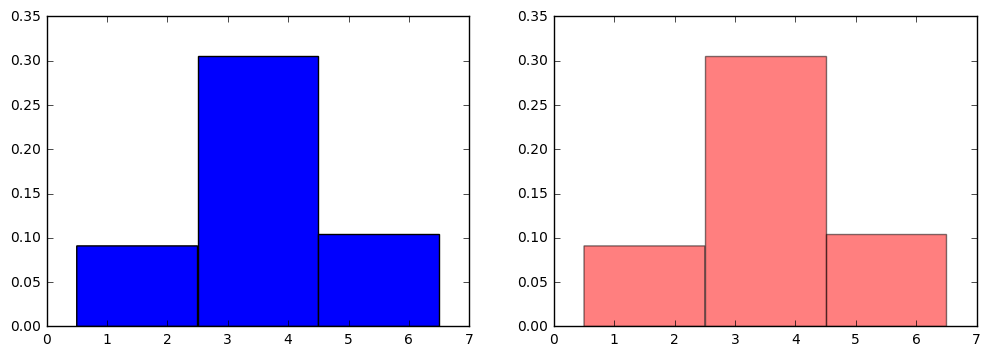

In [20]:

#TRANSFORMING TO UNIFORM DISTRIBUTION
rating_cats = range(1,6)
rating_counts = np.array([sum(np.array(glRatingsTrain['rating']) == rating) for rating in rating_cats])
transformed_ratings = 1 + np.cumsum(4*rating_counts/float(rating_counts.sum()))
transformed_rating_dict = dict(zip(rating_cats,transformed_ratings))
transformed_rating_dict_inv = {v:k for (k,v) in transformed_rating_dict.items()}

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(glRatingsTest['rating'],normed=True,alpha=1,bins=[0.5,2.5,4.5,6.5]);
plt.subplot(122)
plt.hist(glRatingsTest['rating'].apply(lambda x: transformed_rating_dict[x]),normed=True,alpha=0.5,color='r',\
        bins=[0.5,2.5,4.5,6.5]);

In [263]:
#the two lines below scale to uniform dist
#glRatingsTrain['rating'] = glRatingsTrain['rating'].apply(lambda x: transformed_rating_dict[x])
#glRatingsTest['rating'] = glRatingsTest['rating'].apply(lambda x: transformed_rating_dict[x])

In [315]:

models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'solver': 'adagrad',
                                                      'sgd_step_size':  [0.03, 0.01],
                                                      'num_factors': [5,10,20,40],
                                                      'max_iterations': 100,
                                                      'regularization': reg_array,
                                                      'linear_regularization': [1e-10],
                                                      },
                                                      perform_trial_run=False
                                                      )
'''
models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 0,
                                                      'max_iterations': 2000,
                                                      'regularization': 1e-3,
                                                      'linear_regularization': [10**i for i in range(-4,0)]
                                                      })
'''

SyntaxError: invalid syntax (<ipython-input-315-14119efc939c>, line 9)

In [268]:
#models.get_status()
#models.cancel()
models.get_results().sort('validation_rmse')

Columns:
	model_id	int
	item_id	str
	linear_regularization	float
	max_iterations	int
	num_factors	int
	regularization	float
	solver	str
	target	str
	user_id	str
	training_precision@5	float
	training_recall@5	float
	training_rmse	float
	validation_precision@5	float
	validation_recall@5	float
	validation_rmse	float

Rows: 6

Data:
+----------+---------+-----------------------+----------------+-------------+
| model_id | item_id | linear_regularization | max_iterations | num_factors |
+----------+---------+-----------------------+----------------+-------------+
|    2     |  bookID |         1e-10         |      100       |      1      |
|    4     |  bookID |         1e-10         |      100       |      1      |
|    3     |  bookID |         1e-10         |      100       |      2      |
|    5     |  bookID |         1e-10         |      100       |      2      |
|    1     |  bookID |         1e-10         |      100       |      2      |
|    0     |  bookID |         1e-10         |      100       |      1      |
+----------+---------+-----------------------+----------------+-------------+
+----------------+--------+--------+---------+----------------------+
| regularization | solver | target | user_id | training_precision@5 |
+----------------+--------+--------+---------+----------------------+
|     0.0001     |  sgd   | rating |  userID |   0.0124783362218    |
|     5e-05      |  sgd   | rating |  userID |   0.00693240901213   |
|     0.0001     |  sgd   | rating |  userID |   0.0180242634315    |
|     5e-05      |  sgd   | rating |  userID |   0.0103986135182    |
|     0.005      |  sgd   | rating |  userID |   0.0658578856153    |
|     0.005      |  sgd   | rating |  userID |   0.0658578856153    |
+----------------+--------+--------+---------+----------------------+
+-------------------+----------------+------------------------+
| training_recall@5 | training_rmse  | validation_precision@5 |
+-------------------+----------------+------------------------+
| 0.000720201131958 | 0.816356018306 |         0.0034         |
| 0.000482963769555 | 0.811840472836 |         0.002          |
|  0.00100685548973 | 0.789775310228 |         0.0042         |
| 0.000795488810144 | 0.782283890719 |         0.0042         |
|  0.00445835968277 | 0.873117341044 |         0.0218         |
|  0.00445835968277 | 0.873109410456 |         0.0212         |
+-------------------+----------------+------------------------+
+---------------------+-----------------+
| validation_recall@5 | validation_rmse |
+---------------------+-----------------+
|   0.00108564972894  |  0.884693660096 |
|  0.000880903214433  |  0.887145087934 |
|   0.00119645160912  |  0.890168594334 |
|   0.0013386538428   |  0.899435484145 |
|   0.00598435781233  |  0.901348094457 |
|   0.00589813202908  |  0.901370459921 |
+---------------------+-----------------+
[6 rows x 15 columns]

In [ ]:
'''
test=models.get_models()[3].get('coefficients')['bookID']
factors=[row['factors'][0]  for row in test]
test2=test.to_dataframe().ix[np.argsort(factors)]

for i in range(10):
    bID = test2.iloc[i]['bookID']
    print bookTitle(bID)
    
print '\n'

for i in range(10):
    bID = test2[::-1].iloc[i]['bookID']
    print bookTitle(bID)
    '''

In [105]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='sgd',
                                                    max_iterations=50,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-10,
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 90015 observations with 943 users and 1662 items.

Data prepared in: 0.186388s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11251 / 90015 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.818226          | 0.997516                                 |

| 1       | 0.409113          | 0.890052                                 |

| 2       | 0.204556          | 0.766723                                 |

| 3       | 0.102278          | 0.732738                                 |

| 4       | 0.0511391         | 0.756788                                 |

| 5       | 0.0255695         | 0.799368                                 |

| 6       | 0.0127848         | 0.84887                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.102278          | 0.732738                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 1.26529           | 1.12485               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 588.911ms    | 1.08389           | 1.0411                | 0.102278    |

| 2       | 1.16s        | 0.907912          | 0.952843              | 0.0100208   |

| 3       | 1.72s        | 0.856969          | 0.925726              | 0.0052685   |

| 4       | 2.32s        | 0.848851          | 0.921331              | 0.0035737   |

| 5       | 2.89s        | 0.844839          | 0.919151              | 0.00270389  |

| 6       | 3.47s        | 0.842984          | 0.918141              | 0.00217461  |

| 10      | 6.08s        | 0.838984          | 0.915961              | 0.00121964  |

| 11      | 6.66s        | 0.838438          | 0.915663              | 0.00109899  |

| 15      | 8.88s        | 0.837179          | 0.914975              | 0.000787409 |

| 20      | 11.75s       | 0.836253          | 0.914469              | 0.000581374 |

| 25      | 14.65s       | 0.835726          | 0.914181              | 0.0004608   |

| 30      | 17.59s       | 0.835352          | 0.913976              | 0.000381648 |

| 35      | 20.43s       | 0.835081          | 0.913828              | 0.000325702 |

| 40      | 23.31s       | 0.834871          | 0.913713              | 0.000284062 |

| 45      | 26.19s       | 0.834708          | 0.913624              | 0.000251861 |

| 50      | 29.03s       | 0.834578          | 0.913552              | 0.000226218 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.833831

Final training RMSE: 0.913143

In [108]:
print rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.941148950658


In [150]:
rec_engine = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=40,
                                                    solver='sgd',
                                                    max_iterations=50,
                                                    regularization = (1e-2)/(glRatingsTrain.shape[0]),
                                                    linear_regularization = (1e-2)/glRatingsTrain.shape[0],
                                                    random_seed=np.random.randint(1e5)
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 90015 observations with 943 users and 1662 items.

Data prepared in: 0.144847s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 40       |

| regularization                 | L2 Regularization on Factors                     | 1.11e-07 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1.11e-07 |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 129us        | 1.26528           | 1.12485               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 528.152ms    | 1.16029           | 1.07717               | 0.001       |

| 2       | 1.03s        | 1.05507           | 1.02716               | 0.000594604 |

| 3       | 1.50s        | 1.01805           | 1.00898               | 0.000438691 |

| 4       | 2.01s        | 0.997337          | 0.998665              | 0.000353553 |

| 5       | 2.50s        | 0.983546          | 0.991735              | 0.00029907  |

| 6       | 3.02s        | 0.973488          | 0.986651              | 0.000260847 |

| 10      | 5.07s        | 0.949818          | 0.974581              | 0.000177828 |

| 11      | 5.56s        | 0.946004          | 0.972622              | 0.00016556  |

| 15      | 7.62s        | 0.934641          | 0.966763              | 0.000131199 |

| 20      | 10.26s       | 0.925328          | 0.961933              | 0.000105737 |

| 25      | 12.81s       | 0.918787          | 0.958526              | 8.94427e-05 |

| 30      | 15.42s       | 0.913827          | 0.955935              | 7.80116e-05 |

| 35      | 17.95s       | 0.909877          | 0.953866              | 6.94943e-05 |

| 40      | 20.55s       | 0.90662           | 0.952157              | 6.28717e-05 |

| 45      | 23.16s       | 0.903866          | 0.95071               | 5.7556e-05  |

| 50      | 25.73s       | 0.901492          | 0.94946               | 5.3183e-05  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.901082

Final training RMSE: 0.949244

In [152]:
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
#print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - np.array(glRatingsTest['rating']).std()
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.9610264597
0.0198775090424


In [480]:
file_path_train='gl_gr_train'
file_path_test='gl_gr_test'

glRatingsTrain['userID','bookID','rating'].export_csv(file_path_train,header=True,delimiter='\t')
glRatingsTest['userID','bookID','rating'].export_csv(file_path_test,header=True,delimiter='\t')

#glRatingsTrain = gl.SFrame.read_csv(file_path_train,header=True,delimiter='\t')
#glRatingsTest = gl.SFrame.read_csv(file_path_test,header=True,delimiter='\t')

In [481]:
from surprise import SVD, KNNBaseline
from surprise import Dataset, Reader
from surprise import evaluate, GridSearch, print_perf

In [482]:
reader = Reader(line_format='user item rating', sep='\t', skip_lines=1)
surpriseTrain = Dataset.load_from_file(file_path_train, reader=reader).build_full_trainset()

train_folds = Dataset.load_from_file(file_path_train, reader=reader)
train_folds.split(5)

In [52]:
kNNBaseline_GridSearch = GridSearch(KNNBaseline, {'k':range(30,70,5)}, measures=['rmse','fcp'])
kNNBaseline_GridSearch.evaluate(train_folds)

------------
Parameters combination 1 of 8
params:  {'k': 30}
Evaluating RMSE, FCP of algorithm KNNBaseline.

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.8905
Mean FCP : 0.6524
------------
------------
Parameters combination 2 of 8
params:  {'k': 35}
Evaluating RMSE, FCP of algorithm KNNBaseline.

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarit

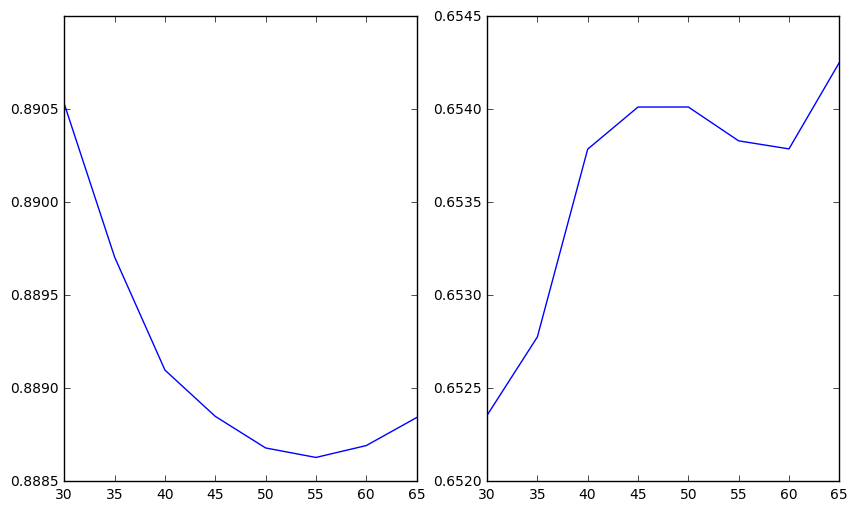

In [156]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot([kNNBaseline_GridSearch.cv_results['params'][i]['k'] for i in range(8)],
        [kNNBaseline_GridSearch.cv_results['scores'][i]['RMSE'] for i in range(8)])
plt.subplot(122)
plt.plot([kNNBaseline_GridSearch.cv_results['params'][i]['k'] for i in range(8)],
        [kNNBaseline_GridSearch.cv_results['scores'][i]['FCP'] for i in range(8)])

In [157]:
gr_KNNBaseline = KNNBaseline(k=kNNBaseline_GridSearch.best_params['rmse']['k'])

gr_KNNBaseline.train(surpriseTrain)


preds=[gr_KNNBaseline.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
preds_est = np.array([preds[i].est for i in range(len(preds))])
preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

errs = preds_true - preds_est
rmse = np.sqrt((errs**2).mean())
rmse

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


0.87933056319020175

In [14]:
SVD_GridSearch = GridSearch(SVD, {'n_factors': [2,20,40,80], 'reg_all': [0.01,0.005,0.001],
                                  'n_epochs':[200], 'lr_all': [0.005,0.001]}, 
                            measures=['rmse','fcp'])
SVD_GridSearch.evaluate(train_folds)

------------
Parameters combination 1 of 24
params:  {'lr_all': 0.005, 'reg_all': 0.01, 'n_factors': 2, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 0.9175
Mean FCP : 0.6444
------------
------------
Parameters combination 2 of 24
params:  {'lr_all': 0.005, 'reg_all': 0.01, 'n_factors': 20, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 1.0618
Mean FCP : 0.6022
------------
------------
Parameters combination 3 of 24
params:  {'lr_all': 0.005, 'reg_all': 0.01, 'n_factors': 40, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 1.0275
Mean FCP : 0.6027
------------
------------
Parameters combination 4 of 24
params:  {'lr_all': 0.005, 'reg_all': 0.01, 'n_factors': 80, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 0.9521
Mean FCP : 0.6228
------------
------------
Parameters combination 5 of 24
params:  {'lr_all': 0.005, 'reg_all': 0.005, 'n_factors': 2, 

In [17]:
#[d1.update(SVD_GridSearch.param_combinations[i]) for i, d1 in enumerate(SVD_GridSearch.param_combinations)]
gl.SFrame({'reg_all': SVD_GridSearch.cv_results['reg_all'], 'n_factors': [d['n_factors'] for d in SVD_GridSearch.cv_results['params']],
         'lr_all': SVD_GridSearch.cv_results['lr_all'],
           'RMSE': [s['RMSE'] for s in SVD_GridSearch.cv_results['scores']],
         'FCP': [s['FCP'] for s in SVD_GridSearch.cv_results['scores']]}).sort('RMSE').print_rows(24)

+----------------+----------------+--------+-----------+---------+
|      FCP       |      RMSE      | lr_all | n_factors | reg_all |
+----------------+----------------+--------+-----------+---------+
| 0.658816844948 | 0.881114009832 | 0.001  |     80    |  0.005  |
| 0.658972666441 | 0.881275301696 | 0.001  |     80    |  0.001  |
| 0.658531046024 | 0.881671574717 | 0.001  |     80    |   0.01  |
| 0.655860179266 | 0.883307399724 | 0.001  |     40    |   0.01  |
| 0.653419565519 | 0.885141631642 | 0.001  |     40    |  0.005  |
| 0.651917553787 | 0.888176266942 | 0.001  |     40    |  0.001  |
| 0.644867183113 | 0.894709452233 | 0.001  |     20    |   0.01  |
| 0.641634935956 | 0.899068238663 | 0.001  |     20    |  0.005  |
| 0.639283722254 | 0.902705254105 | 0.001  |     20    |  0.001  |
| 0.63432263678  |  0.9110994778  | 0.001  |     2     |   0.01  |
| 0.633632151623 | 0.91248615054  | 0.001  |     2     |  0.005  |
|  0.632717285   | 0.914431995953 | 0.001  |     2     |  0.00

In [483]:
gr_SVD = SVD(lr_all=0.001, n_epochs=200, n_factors=80, reg_all=0.005)
#gr_SVD = SVD_GridSearch.best_estimator['rmse']
gr_SVD.train(surpriseTrain)


preds=[gr_SVD.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
preds_est = np.array([preds[i].est for i in range(len(preds))])
preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

errs = preds_true - preds_est
rmse = np.sqrt((errs**2).mean())
rmse

0.89249663812313351

In [747]:
to_outer_iid = {surpriseTrain.to_inner_iid(bID): bID for bID in glRatingsTrain['bookID']}


factor_norms_sq = np.array([gr_SVD.qi[:,i].dot(gr_SVD.qi[:,i]) for i in range(80)])
factor_argsort = np.argsort(factor_norms_sq)
for i in range(1):
    factor = gr_SVD.qi[:,factor_argsort[i]]
    loadings_argsort = np.argsort(factor)
    for j in range(5):
        print bookTitle(to_outer_iid[loadings_argsort[j]])
        print factor[loadings_argsort[j]]
    print '\n'
    for j in range(5):
        print bookTitle(to_outer_iid[loadings_argsort[::-1][j]])
        print factor[loadings_argsort[::-1][j]]

IndexError: list index out of range

In [745]:
loadings_argsort

array([ 20, 209, 203, ...,  39,  19, 132])

SOCIAL MODELS

In [484]:
glCommMeansTrain, glCommBookMeansTrain, commMeansTrain, commBookMeansTrain = \
makeSocialModelInputs(glRatingsTrainWithComm)

In [644]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})

numRatingsByBook = glRatingsTrain.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByBookDict = defaultdict(int, {r['bookID']: r['numRatings'] for r in numRatingsByBook})

numTrainRatings_Test = np.array(glRatingsTestWithComm['bookID'].apply(lambda x: numRatingsByBookDict[x]))

0.50606620188751883

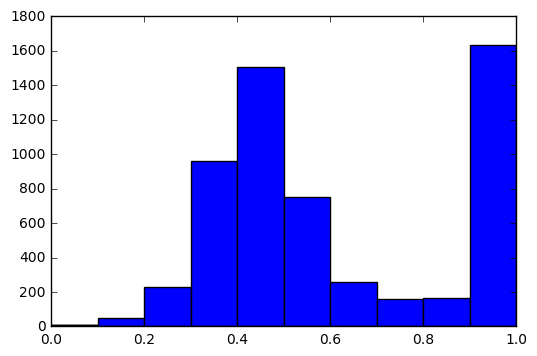

In [650]:
adjXmax = 100.
adjX = numTrainRatings_Test.copy()
adjX[adjX>adjXmax] = adjXmax
adjWeights = np.tan(2.7*(adjX-(adjXmax/2))/adjXmax)
adjWeights = adjWeights / (max(adjWeights)-min(adjWeights))
adjWeights = adjWeights - min(adjWeights)

#plt.plot(numTrainRatings_Test, adjWeights, 'o')
plt.hist(adjWeights)
np.median(adjWeights)

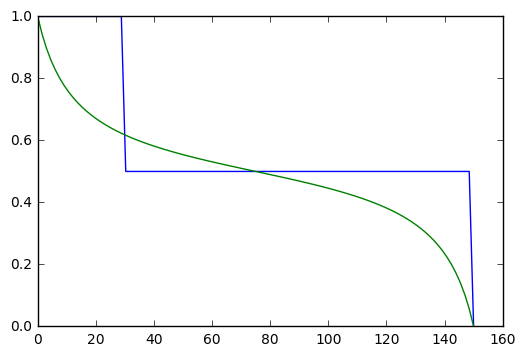

In [487]:
'''
adjWeights=(100. - np.linspace(0,100,100))/100.
adjWeights[adjWeights<0]=0
adjWeights = adjWeights**(0.5)
plt.plot(np.linspace(0,100,100), adjWeights)
'''
adjX = np.linspace(0,150,100)
adjWeights = 0.5*(adjX<30) + 0.5*(adjX < 150)
adjWeights2 = np.tan(-2.7*(adjX-75)/150)
adjWeights2 = adjWeights2 / (2*max(adjWeights2))
adjWeights2 = adjWeights2 - min(adjWeights2)
plt.plot(adjX, adjWeights)
plt.plot(adjX, adjWeights2)


In [658]:
rec_engine = surprisePredWrapper(gr_SVD)

meanWeights = np.linspace(0,0.5,20)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimpleNew = []

for weight in meanWeights:
    rmsesSimpleNew.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])


'''
#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])

trainSplitRmses.append(rmsesSimpleNoBookMeans)
'''    
#SANITY CHECK
'''
rmsesFake = []

for weight in meanWeights:
    rmsesFake.append(\
                mixedPred(glRatingsTestFakeComms, \
                          fakeCommMeansTrain, fakeCommBookMeansTrain, fakeCommBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test,\
                          False, False, False, weight)[1])

#FACTORIZING COMM MEANS
rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8 \
                          commMeans_rec_engine_baseline, True, False, True, weight)[1])
'''

'\nrmsesFake = []\n\nfor weight in meanWeights:\n    rmsesFake.append(                mixedPred(glRatingsTestFakeComms,                           fakeCommMeansTrain, fakeCommBookMeansTrain, fakeCommBookMeansTrain, rec_engine, rec_engine,                           numTrainRatings_Test,                          False, False, False, weight)[1])\n\n#FACTORIZING COMM MEANS\nrmsesFac = []\nfor weight in meanWeights:\n    rmsesFac.append(                mixedPred(glRatingsTestWithComm,                           commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8                           commMeans_rec_engine_baseline, True, False, True, weight)[1])\n'

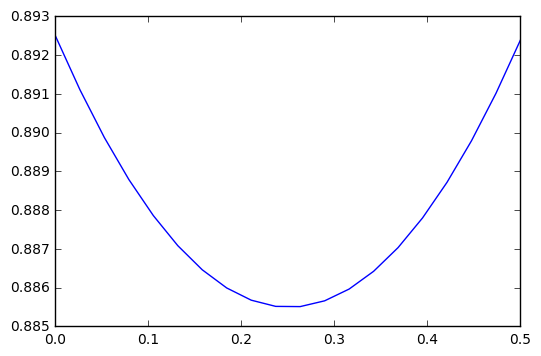

In [663]:
plt.plot(meanWeights, rmsesSimple)
optimalWeight = meanWeights[np.argmin(rmsesSimple)]

In [664]:
optimalPreds = pd.Series(mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, optimalWeight)[0])

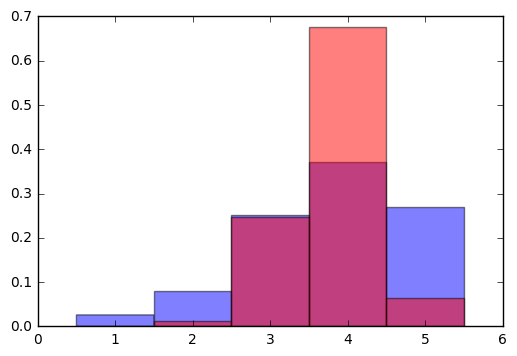

In [665]:
plt.hist(glRatingsTest['rating'],normed=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5],alpha=0.5);
plt.hist(optimalPreds,normed=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5],alpha=0.5,color='r');

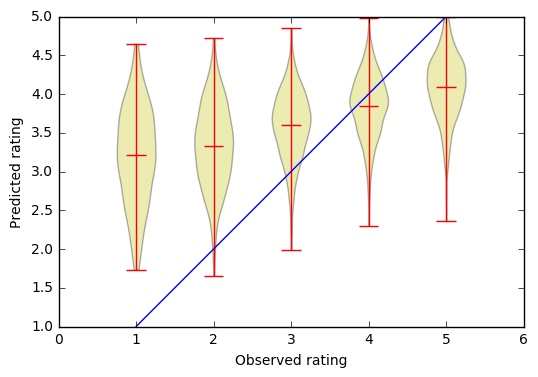

In [666]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(optimalPreds[pd.Series(glRatingsTestWithComm['rating'] == rating).astype(bool)]))

plt.violinplot(preds_by_rating, positions=rating_cats,showmeans=True);
plt.plot([1,5],[1,5])
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');

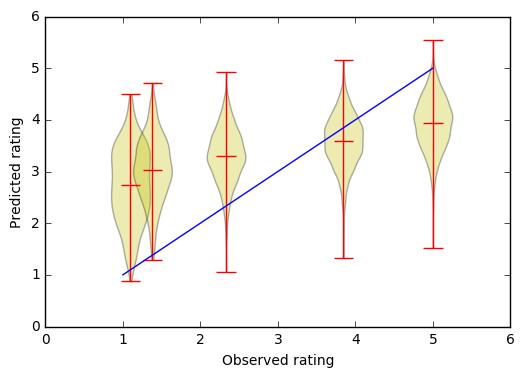

In [337]:
preds_by_rating = []
rating_cats = range(1,6)

interval_eps = 0.001;
transformed_rating_intervals = [(transformed_rating_dict[r] - 0.001, transformed_rating_dict[r] + 0.001)\
                                for r in rating_cats]

for rating in rating_cats:
    preds_by_rating.append(list(optimalPreds[pd.Series(glRatingsTestWithComm['rating'] == rating).astype(bool)]))

plt.violinplot(preds_by_rating, positions=[transformed_rating_dict[r] for r in rating_cats],showmeans=True);
plt.plot([min(transformed_rating_dict),max(transformed_rating_dict)],[min(transformed_rating_dict),max(transformed_rating_dict)])
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');

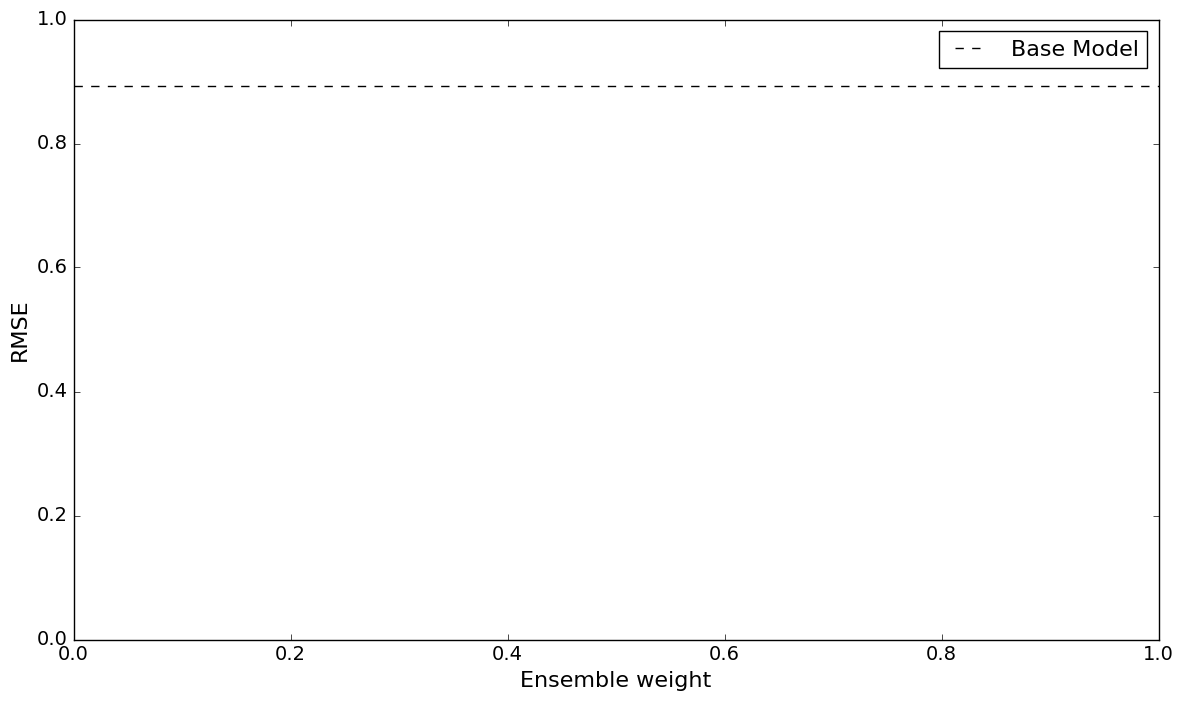

In [667]:
plt.figure(figsize=(14,8))

blueLabel = {0: 'Ensemble Models', 1: None, 2: None}
greenLabel = defaultdict(lambda: None,{0: 'Fake Community Models'})

for i, rmsesSimpleNoBookMeans in enumerate(trainSplitRmses):
    plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-', color='b', label=blueLabel[i], alpha=0.85);
#plt.plot(meanWeights, rmsesFake, '-', label='Sanity check');
plt.axhline(rmsesSimpleNoBookMeans[0],color='k',linestyle='--', label='Base Model');
#plt.axhline(rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)],linestyle='--',label='Best Combined Model')

for i, curve in enumerate([curve for bootstrapRmsesFake in trainSplitRmsesFake for curve in bootstrapRmsesFake]):
    plt.plot(meanWeights, curve, color='g', label=greenLabel[i], alpha=0.25)
#plt.axhline(np.mean(bootstrapRmsesFake),linestyle='--',color='g',label='Mean Sanity Check Model')

plt.xlabel('Ensemble weight',fontsize=16)
plt.ylabel('RMSE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=16);

In [338]:
#print meanWeights[np.argmin(rmsesFake)]
#print rmsesFake[np.argmin(rmsesFake)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]


0.315789473684
0.898996257624


USING COMMUNITY MEANS OF RECOMMENDER PREDICTIONS

In [208]:
test = [(bookID, userID) for bookID, userID in product(glRatings['bookID'].unique(), glRatings['userID'].unique())]

In [209]:
#test
testDict = {}
npTest = np.array(test)
testDict['bookID'] = npTest[:,0]
testDict['userID'] = npTest[:,1]
sfTest = gl.SFrame(testDict)

In [210]:
allPreds = rec_engine.predict(sfTest)

In [211]:
sfTest.add_column(gl.SArray(allPreds), 'preds')

bookID,userID,preds
1162543,32119,2.07435641835
1162543,271433,2.68663620884
1162543,5247,1.881069127
1162543,14871,2.45840641329
1162543,247244,2.21480927816
1162543,94602,2.3777080937
1162543,9169100,2.04542950553
1162543,11773284,3.02855442599
1162543,94664,2.71134952976
1162543,24243723,2.98973484204


In [212]:
commDict = {uID: i for i, comm in enumerate(allComms) for uID in comm}

sfTest.add_column(sfTest['userID'].apply(lambda x: commDict[int(x)]), 'comm')

bookID,userID,preds,comm
1162543,32119,2.07435641835,8
1162543,271433,2.68663620884,51
1162543,5247,1.881069127,69
1162543,14871,2.45840641329,22
1162543,247244,2.21480927816,17
1162543,94602,2.3777080937,42
1162543,9169100,2.04542950553,64
1162543,11773284,3.02855442599,42
1162543,94664,2.71134952976,30
1162543,24243723,2.98973484204,44


In [213]:
sfTest[['bookID', 'preds', 'comm']].groupby(['bookID', 'comm'], {'avgPreds': gl.aggregate.AVG('preds')})

bookID,comm,avgPreds
10569,55,4.25975653626
11278959,59,3.39406133016
28381,4,4.14808230681
17336704,24,3.5963875691
485894,49,3.72801938803
7937843,46,3.67293725445
33453,45,3.56789518135
420282,2,3.76337596362
17401600,60,4.35406963591
216363,4,3.57949151096


In [214]:
factorCommBookMeansTrain = {(row['bookID'], row['comm']):  row['preds'] for row in sfTest}

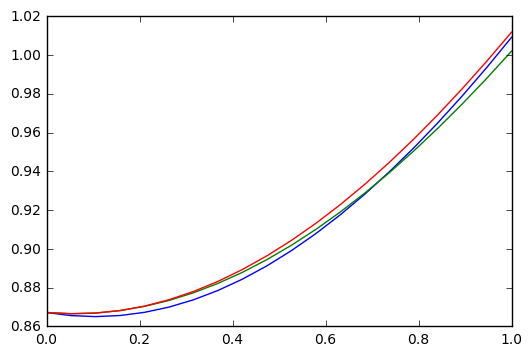

In [238]:
meanWeights = np.linspace(0,1,20)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS

rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          True, False, True, weight)[1])

plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesFac, '-')

In [239]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

0.105263157895
0.86507521851


In [157]:
predsBase = np.array(rec_engine.predict(glRatingsTestWithComm['bookID', 'userID']))

FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA

In [497]:
#glCommTrain = glRatingsTrainWithComm.copy()['bookID', 'comm', 'rating']
#glCommTest = glRatingsTestWithComm.copy()['bookID', 'comm', 'rating']
glCommTrain = glCommBookMeansTrain.copy()

glCommTrain['rating'] = glCommTrain['meanBookRatingByComm']
glCommTrain.remove_column('meanBookRatingByComm')

bookID,comm,rating
7937843,46,4.0
4407,30,3.0
64582,46,4.0
20910157,41,3.0
7770,58,5.0
2429135,46,3.5
4953,23,2.0
116257,75,4.5
10441,49,2.0
5355,13,4.0


In [498]:
glCommMeansTest, glCommBookMeansTest, commMeansTest, commBookMeansTest = \
makeSocialModelInputs(glRatingsTestWithComm)

glCommTest = glCommBookMeansTest.copy()
glCommTest['rating'] = glCommTest['meanBookRatingByComm']
glCommTest.remove_column('meanBookRatingByComm')

bookID,comm,rating
485894,49,3.0
5043,24,3.0
10441,49,3.0
1,4,4.0
4137,60,4.0
37442,13,3.0
8337,69,5.0
21,49,5.0
5093,36,1.0
4667024,46,4.0


In [499]:
file_path_train_comm='gl_gr_train_comm'
file_path_test_comm='gl_gr_test_comm'

glCommTrain['comm','bookID','rating'].export_csv(file_path_train_comm,header=True,delimiter='\t')
glCommTest['comm','bookID','rating'].export_csv(file_path_test_comm,header=True,delimiter='\t')

#glCommTrain = gl.SFrame.read_csv(file_path_train_comm,header=True,delimiter='\t')
#glCommTest = gl.SFrame.read_csv(file_path_test_comm,header=True,delimiter='\t')

In [500]:
reader = Reader(line_format='user item rating', sep='\t', skip_lines=1)
surpriseTrainComm = Dataset.load_from_file(file_path_train_comm, reader=reader).build_full_trainset()

train_folds_comm = Dataset.load_from_file(file_path_train_comm, reader=reader)
train_folds_comm.split(5)

In [501]:
SVD_GridSearch.best_params['rmse']

{'lr_all': 0.001, 'n_epochs': 200, 'n_factors': 80, 'reg_all': 0.005}

In [502]:
gr_SVD_comm = SVD(lr_all=0.001, n_epochs=200, n_factors=80, reg_all=0.005)
gr_SVD_comm.train(surpriseTrainComm)

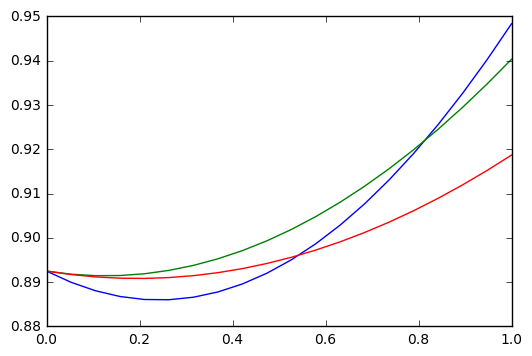

In [668]:
rec_engine_comm = surprisePredWrapper(gr_SVD_comm)

meanWeights = np.linspace(0,1,20)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimple = []
for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])
                          

#FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA
rmsesSocialRec = []

for weight in meanWeights:
    rmsesSocialRec.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])


plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesSocialRec, '-');


In [669]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

print ''


print meanWeights[np.argmin(rmsesSocialRec)]
print rmsesSocialRec[np.argmin(rmsesSocialRec)]

0.263157894737
0.886030994763

0.105263157895
0.891465926694

0.210526315789
0.890843390946


In [670]:
bestWeightComm = meanWeights[np.argmin(rmsesSimple)]

predsComm = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, False, True, bestWeightComm)[0]

predsBase = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, False, True, 0)[0]

In [671]:
signTestFrame = glRatingsTestWithComm[['bookID','userID','comm','rating']].copy()
signTestFrame.add_column(gl.SArray(predsComm), 'predsComm')
signTestFrame.add_column(gl.SArray(predsBase), 'predsBase')

bookID,userID,comm,rating,predsComm,predsBase
18490,160216,30,4,3.71746775162,3.97370623434
2956,160216,30,2,4.07973416146,3.84035350484
3690,160216,30,4,4.23164070992,4.24059542213
1852,160216,30,5,4.02244596266,4.01859607326
51933,160216,30,5,4.03612129368,4.03602860608
3876,160216,30,3,3.96018133696,4.04094711872
298275,160216,30,3,3.96940903402,3.96525453014
2794,160216,30,3,4.04125484531,4.04504839431
37415,1,67,2,3.97181537208,3.96642583509
6310,1,67,5,4.14909256181,4.24007403442


In [672]:
errsBase = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsBase'])**2)
errsBase

errsComm = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsComm'])**2)
(errsComm < errsBase).mean()

0.52178477690288716

In [673]:
signTestFrame.add_column(gl.SArray(errsComm), 'errsComm')
signTestFrame.add_column(gl.SArray(errsBase), 'errsBase')

bookID,userID,comm,rating,predsComm,predsBase,errsComm,errsBase
18490,160216,30,4,3.71746775162,3.97370623434,0.0798244713763,0.000691362112721
2956,160216,30,2,4.07973416146,3.84035350484,4.32529418234,3.38690102277
3690,160216,30,4,4.23164070992,4.24059542213,0.0536574184921,0.0578861571498
1852,160216,30,5,4.02244596266,4.01859607326,0.955611895923,0.963153667414
51933,160216,30,5,4.03612129368,4.03602860608,0.929062160498,0.929240848287
3876,160216,30,3,3.96018133696,4.04094711872,0.921948199854,1.08357090398
298275,160216,30,3,3.96940903402,3.96525453014,0.93975387523,0.931716307965
2794,160216,30,3,4.04125484531,4.04504839431,1.08421165289,1.09212614644
37415,1,67,2,3.97181537208,3.96642583509,3.88805586159,3.86683056489
6310,1,67,5,4.14909256181,4.24007403442,0.724043468375,0.577487473169


In [674]:
signTestFrame.groupby(['rating'], {'errsCommAvg': gl.aggregate.AVG('errsComm'),\
                                  'errsBaseAvg': gl.aggregate.AVG('errsBase')}).sort('rating')

rating,errsBaseAvg,errsCommAvg
1,5.29546282365,5.26720772137
2,2.05434217211,2.0700315958
3,0.573810889699,0.559723086919
4,0.218707347517,0.193539382636
5,0.996144936364,0.999498142704


In [675]:
roundedPredsBase = np.round(predsBase)
roundedPredsComm = np.round(predsComm)

In [676]:
(roundedPredsBase == signTestFrame['rating']).mean()

0.42204724409448818

In [677]:
(roundedPredsComm == signTestFrame['rating']).mean()

0.42274715660542433

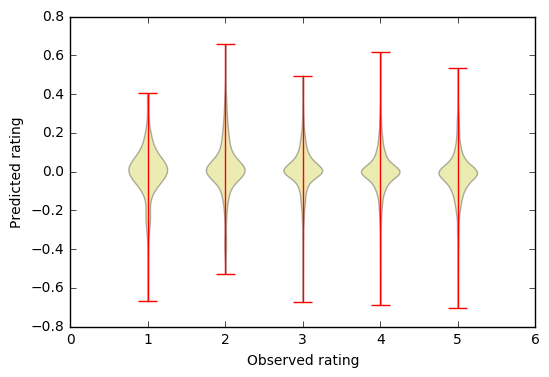

In [678]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(predsComm[np.array(glRatingsTest['rating']) == rating]\
                          -predsBase[np.array(glRatingsTest['rating']) == rating]))

plt.violinplot(preds_by_rating, positions=rating_cats);
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');
#for rating in rating_cats:
#    plt.axhline(rating,linestyle='--',linewidth=1,alpha=0.5)

In [680]:
for i, category in enumerate(preds_by_rating):
    print (i+1, np.median(category))

(1, 0.010254312137463417)
(2, 0.011249610651759667)
(3, 0.0060427418890518503)
(4, 0.00025073161466848681)
(5, -0.010010548353368565)


3.7992144357159514

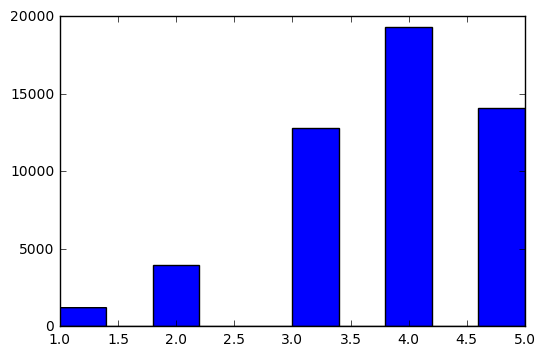

In [681]:
plt.hist(glRatingsTrain['rating'])
(glRatingsTrain['rating']).mean()

In [963]:
coef_dict = rec_engine.get('coefficients')

In [964]:
coef_dict['userID']

userID,linear_terms,factors
13389,0.449082821608,"[-2.9401418189e-08,-2.47457433034e-06, ..."
147129,0.018716853112,"[6.31890827663e-07,-1.23543497921e-06, ..."
82625,0.256159394979,"[1.29775025925e-06,1.10020755528e-06, ..."
12251,0.671747028828,"[-1.14628380743e-06,-3.97139643837e-07, ..."
160216,0.0298878327012,"[5.05336538481e-06,7.61476530897e-06, ..."
1,0.368342787027,"[-3.67200627807e-05,5.10490754095e-05, ..."
546,0.484111756086,"[-2.40624467551e-06,-3.51996568497e-05, ..."
609,-0.215856999159,"[-2.25407035259e-07,8.75285149959e-06, ..."
657,0.242997214198,"[3.48835055775e-06,1.58360251135e-06, ..."
25943,-0.445351481438,"[1.295065249e-05,-2.90351563308e-05, ..."


In [881]:
s = set(glRatings['bookID'].unique())
numCommsByBook = {k: len(v) for k, v in booksToRaterComms.items() if str(k) in s}

In [882]:
[(k, v) for k, v in numCommsByBook.items() if v == 40]

[(6310, 40),
 (49041, 40),
 (7445, 40),
 (6514, 40),
 (4473, 40),
 (37415, 40),
 (62291, 40),
 (11275, 40),
 (7588, 40),
 (1622, 40)]

In [892]:
for bID in [k for k, v in numCommsByBook.items() if v  == 50]:
    print bID
    print bookTitle(bID)

2429135
(u'The Girl with the Dragon Tattoo\n      \n          (Millennium #1)', 1766752)
48855
(u'The Diary of a Young Girl', 1900271)
168668
(u'Catch-22\n      \n          (Catch-22 #1)', 540094)
13496
(u'A Game of Thrones\n      \n          (A Song of Ice and Fire #1)', 1300530)
41865
(u'Twilight\n      \n          (Twilight  #1)', 3635695)
43641
(u'Water for Elephants', 1044043)
3985
(u'The Amazing Adventures of Kavalier & Clay', 147815)


In [894]:
testBID = 2429135

commIndices = []
allCommBookRatings = []
numRaters = []
meanRatings = []
earliestTimes = []

uIDsInGL = set(glRatings['userID'].unique())

for commIndex in booksToRaterComms[testBID]:
    commRatings = ratingsFull.find({'userID': {'$in': list(set(allComms[commIndex]) & uIDsInGL)}})
    commBookRatings = [(r['ratings'][str(testBID)][0], \
                        datetime.strptime(r['ratings'][str(testBID)][2], grDateFormat), \
                        r['userID'])\
                       for r in commRatings if str(testBID) in r['ratings'].keys()]
    allCommBookRatings.append(commBookRatings)
    
    commIndices.append(commIndex)
    numRaters.append(len(commBookRatings))
    meanRatings.append(np.mean(np.array(commBookRatings)[:,0]))
    earliestTimes.append(min(r[1] for r in commBookRatings))

timeOrder = np.argsort(earliestTimes)

numRatersCumSum = 0
for i in timeOrder:
    numRatersCumSum += numRaters[i]
    if numRaters[i] > 3:
        print 'Community %d' % commIndices[i]
        print '%d raters' % numRaters[i]
        print '%.1f mean rating' % meanRatings[i]
        print 'Earliest rating on %s' % datetime.strftime(earliestTimes[i], grDateFormat)
        print '\nTotal raters thus far: %d\n' % numRatersCumSum

Community 46
5 raters
2.8 mean rating
Earliest rating on Sep 25, 2008

Total raters thus far: 5

Community 10
14 raters
3.4 mean rating
Earliest rating on Nov 17, 2008

Total raters thus far: 22

Community 70
4 raters
4.0 mean rating
Earliest rating on Jan 23, 2009

Total raters thus far: 26

Community 65
12 raters
3.7 mean rating
Earliest rating on Apr 11, 2009

Total raters thus far: 41

Community 21
7 raters
3.4 mean rating
Earliest rating on Jul 15, 2009

Total raters thus far: 50

Community 33
8 raters
3.0 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 58

Community 23
6 raters
3.2 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 64

Community 49
9 raters
3.6 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 73

Community 68
13 raters
3.7 mean rating
Earliest rating on Aug 28, 2009

Total raters thus far: 86

Community 17
4 raters
2.5 mean rating
Earliest rating on Sep 23, 2009

Total raters thus far: 90

Community 67
4 rat

In [103]:
relevantGLratings = glRatings[glRatings.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.print_rows(num_rows=42)

+--------+------+--------+----------+
| bookID | comm | rating |  userID  |
+--------+------+--------+----------+
| 11275  |  48  |   4    | 5455905  |
| 11275  |  48  |   4    | 8943786  |
| 11275  |  48  |   3    | 19569261 |
| 11275  |  48  |   4    | 8864511  |
| 11275  |  48  |   4    | 23434392 |
| 11275  |  48  |   5    | 9069989  |
| 11275  |  48  |   5    | 48801419 |
| 11275  |  48  |   4    | 8068801  |
| 11275  |  48  |   4    | 7551020  |
| 11275  |  48  |   5    | 2392247  |
| 11275  |  48  |   4    | 6512932  |
| 11275  |  48  |   3    | 5011787  |
| 11275  |  48  |   4    | 5724539  |
| 11275  |  48  |   5    | 40547054 |
| 11275  |  48  |   1    | 9136579  |
| 11275  |  48  |   5    | 20931024 |
| 11275  |  48  |   4    | 8481252  |
| 11275  |  48  |   5    | 25218011 |
| 11275  |  48  |   4    | 6308393  |
| 11275  |  48  |   5    | 20187777 |
| 11275  |  48  |   5    | 43756219 |
| 11275  |  48  |   3    | 26363295 |
| 11275  |  48  |   4    | 7756517  |
| 11275  |  

In [124]:
relevantGLratings = signTestFrame[signTestFrame.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsBase']))), \
                             'errsBase')
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsComm']))), \
                             'errsComm')

#relevantGLratings.print_rows(num_rows=42, num_columns=8)
print relevantGLratings['errsBase'].mean()
print relevantGLratings['errsComm'].mean()

0.607146395116
0.592260112867


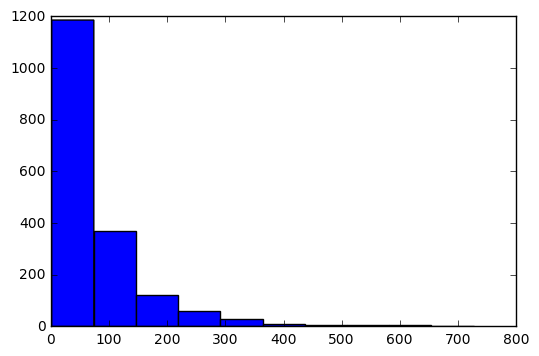

In [173]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByUser['numRatings']);

In [682]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [683]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})

numRatingsByBook = glRatingsTrain.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByBookDict = defaultdict(int, {r['bookID']: r['numRatings'] for r in numRatingsByBook})

In [684]:
pdRatingsTest['numRatingsByUser'] = pdRatingsTest['userID'].apply(lambda x: numRatingsByUserDict[x])
pdRatingsTest['numRatingsByBook'] = pdRatingsTest['bookID'].apply(lambda x: numRatingsByBookDict[x])

In [685]:
pdRatingsTest['numRatingsByUser'].describe()

count    5715.000000
mean       94.543132
std        66.651041
min        15.000000
25%        48.000000
50%        76.000000
75%       116.000000
max       407.000000
Name: numRatingsByUser, dtype: float64

In [686]:
pdRatingsTest['numRatingsByBook'].describe()

count    5715.000000
mean       88.029221
std        90.707186
min         0.000000
25%        26.000000
50%        52.000000
75%       110.000000
max       419.000000
Name: numRatingsByBook, dtype: float64

In [691]:
numRatingsCutoffHigh = 100000
numRatingsCutoffLow = 50
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)).mean()

0.513560804899


In [692]:
numRatingsCutoffHigh = 51
numRatingsCutoffLow = 0
pdFewRatings = pdRatingsTest[(pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)).mean()

0.48573928259


In [689]:
numRatingsCutoffHigh = 100000
numRatingsCutoffLow = 70
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)).mean()

0.545756780402


In [690]:
numRatingsCutoffHigh = 71
numRatingsCutoffLow = 0
pdFewRatings = pdRatingsTest[(pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)).mean()

0.454243219598


In [575]:
meanWeights = np.linspace(0,1,20)

rmsesSimple = []
for weight in meanWeights:
    rmsesSimple.append(mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])


rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])
    
rmsesSimpleFewRatings = []
for weight in meanWeights:
    rmsesSimpleFewRatings.append(mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])


rmsesSocialRecManyRatings = []

for weight in meanWeights:
    rmsesSocialRecManyRatings.append(\
                mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])
    
rmsesSocialRecFewRatings = []

for weight in meanWeights:
    rmsesSocialRecFewRatings.append(\
                mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])

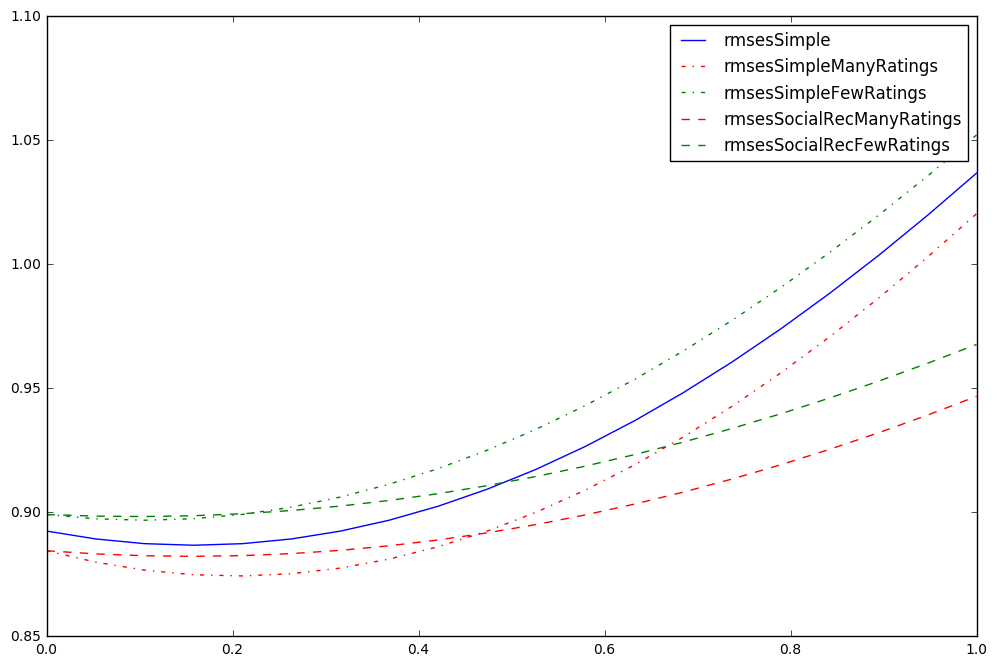

In [576]:
plt.figure(figsize=(12,8))
plt.plot(meanWeights, rmsesSimple,label='rmsesSimple')
plt.plot(meanWeights, rmsesSimpleManyRatings,'-.',color='r',label='rmsesSimpleManyRatings')
plt.plot(meanWeights, rmsesSimpleFewRatings,'-.',color='g',label='rmsesSimpleFewRatings')

plt.plot(meanWeights, rmsesSocialRecManyRatings,'--',color='r',label='rmsesSocialRecManyRatings')
plt.plot(meanWeights, rmsesSocialRecFewRatings,'--',color='g',label='rmsesSocialRecFewRatings')
plt.legend()

In [577]:
print min(rmsesSimple)
print min(rmsesSimpleFewRatings)
print min(rmsesSimpleManyRatings)

0.886774861619
0.896864239747
0.874396819662


array([   24,    67,    68,    92,   102,   110,   111,   130,   136,
         137,   148,   153,   157,   157,   168,   171,   175,   180,
         187,   201,   210,   212,   213,   227,   253,   253,   254,
         260,   267,   291,   294,   304,   310,   334,   336,   339,
         342,   352,   361,   410,   417,   434,   435,   436,   437,
         479,   537,   538,   543,   583,   652,   680,   742,   797,
         802,   838,   855,   869,   933,   955,   985,  1037,  1041,
        1165,  1215,  1244,  1296,  1495,  1655,  1761,  2374,  3410, 11292])

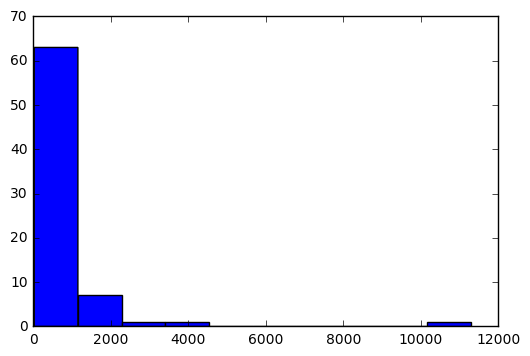

In [693]:
numRatingsByComm = glRatingsTrainWithComm.groupby(['comm'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByComm['numRatings']);
np.sort(numRatingsByComm['numRatings'])

In [694]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [695]:
numRatingsByCommDict = defaultdict(int, {r['comm']: r['numRatings'] for r in numRatingsByComm})

In [696]:
pdRatingsTest['numRatingsByComm'] = pdRatingsTest['comm'].apply(lambda x: numRatingsByCommDict[x])

In [697]:
pdRatingsTest['numRatingsByComm'].describe()

count     5715.000000
mean      3360.497288
std       4268.395299
min         24.000000
25%        583.000000
50%       1215.000000
75%       3410.000000
max      11292.000000
Name: numRatingsByComm, dtype: float64

In [698]:
numRatingsCutoff = 1000
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)]
print ((pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)).mean()

0.562379702537


In [699]:
numRatingsCutoff = 1000
pdFewRatings = pdRatingsTest[(pdRatingsTest['numRatingsByComm'] <= numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)]
print ((pdRatingsTest['numRatingsByComm'] <= numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)).mean()

0.437620297463


In [700]:
meanWeights = np.linspace(0,1,20)

rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])
    
rmsesSimpleFewRatings = []
for weight in meanWeights:
    rmsesSimpleFewRatings.append(mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])


rmsesSocialRecManyRatings = []

for weight in meanWeights:
    rmsesSocialRecManyRatings.append(\
                mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])
    
rmsesSocialRecFewRatings = []

for weight in meanWeights:
    rmsesSocialRecFewRatings.append(\
                mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])

ValueError: operands could not be broadcast together with shapes (5715,) (3214,) 

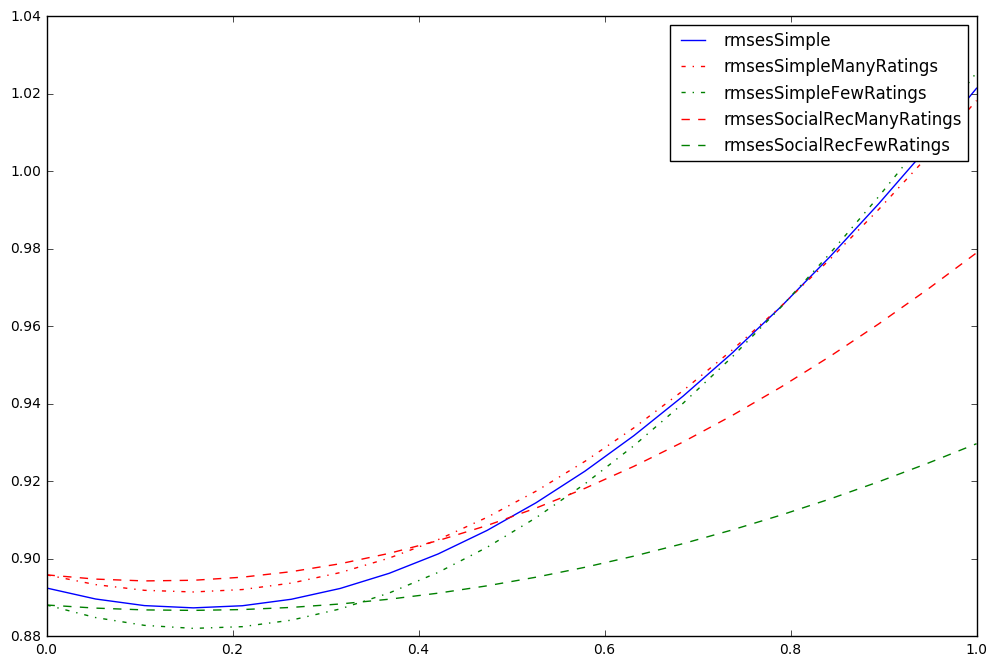

In [540]:
plt.figure(figsize=(12,8))
plt.plot(meanWeights, rmsesSimple,label='rmsesSimple')
plt.plot(meanWeights, rmsesSimpleManyRatings,'-.',color='r',label='rmsesSimpleManyRatings')
plt.plot(meanWeights, rmsesSimpleFewRatings,'-.',color='g',label='rmsesSimpleFewRatings')

plt.plot(meanWeights, rmsesSocialRecManyRatings,'--',color='r',label='rmsesSocialRecManyRatings')
plt.plot(meanWeights, rmsesSocialRecFewRatings,'--',color='g',label='rmsesSocialRecFewRatings')
plt.legend()

In [416]:
print meanWeights[np.argmin(rmsesSimple)]
print meanWeights[np.argmin(rmsesSimpleManyRatings)]
print meanWeights[np.argmin(rmsesSimpleFewRatings)]

0.105263157895
0.0526315789474
0.105263157895


In [414]:
pdManyRatings['userID'].apply(lambda x: numRatingsByUserDict[x]).describe()

count    4965.000000
mean      124.497281
std        81.539893
min        18.000000
25%        65.000000
50%       102.000000
75%       158.000000
max       376.000000
Name: userID, dtype: float64

In [415]:
pdFewRatings['userID'].apply(lambda x: numRatingsByUserDict[x]).describe()

count    4484.000000
mean       98.522971
std        70.383467
min        15.000000
25%        49.000000
50%        81.000000
75%       117.000000
max       400.000000
Name: userID, dtype: float64